## 1. Imports Libraries

In [8]:
# Import libraries
import imgaug as aug
import imgaug.augmenters as iaa
import os
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
import opendatasets as od

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import random
from pathlib import Path #to be able to use functions using path


# Data science tools
import pandas as pd # data processing
import numpy as np # linear algebra

# Tensorflow for GPU
import tensorflow as tf
from tensorflow.compat.v1 import Session, ConfigProto, set_random_seed
from tensorflow.python.client import device_lib

# Keras library for Modeling
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K


# OpenCV
import cv2

# Resize images
from skimage.io import imread
from skimage.transform import resize

# Scikit-learn library
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Visualizations
from PIL import Image
#import imgaug as aug
#import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import matplotlib.image as mimg # images
%matplotlib inline
import seaborn as sns
import plotly.express as px

In [9]:
# Directories
train_dir = Path("../data/chest_xray/train") 
val_dir = Path("../data/chest_xray/val")
test_dir = Path("../data/chest_xray/test") 

## 2. Load the Data

In [10]:
train_normal_dir = train_dir /"NORMAL" 
train_pneumonia_dir = train_dir /"PNEUMONIA" 
valid_normal_dir = val_dir /"NORMAL" 
valid_pneumonia_dir = val_dir /"PNEUMONIA" 
test_normal_dir = test_dir /"NORMAL" 
test_pneumonia_dir = test_dir /"PNEUMONIA"

## 3. Data Exploration and Preprocessing

In [11]:
train_normal= train_normal_dir.glob("*.jpeg") #to take the normal images from train set 
train_pneumonia=train_pneumonia_dir.glob("*.jpeg") #to take the pneumonia images from the train set
train_set=[]#to add all the train data into one list, we created a blank list

In [12]:
for img in train_normal: #to add every image of normals in trainset to the list
  train_set.append((img, 0)) #we add 0 with normal images as label
for img in train_pneumonia:#to add every image of pneumonias in trainset to the list
  train_set.append((img, 1)) #we add 1 with pneumonia images as label

In [13]:
print(train_set[:15]) #to check what our list look like

[(PosixPath('../data/chest_xray/train/NORMAL/IM-0115-0001.jpeg'), 0), (PosixPath('../data/chest_xray/train/NORMAL/IM-0117-0001.jpeg'), 0), (PosixPath('../data/chest_xray/train/NORMAL/IM-0119-0001.jpeg'), 0), (PosixPath('../data/chest_xray/train/NORMAL/IM-0122-0001.jpeg'), 0), (PosixPath('../data/chest_xray/train/NORMAL/IM-0125-0001.jpeg'), 0), (PosixPath('../data/chest_xray/train/NORMAL/IM-0127-0001.jpeg'), 0), (PosixPath('../data/chest_xray/train/NORMAL/IM-0128-0001.jpeg'), 0), (PosixPath('../data/chest_xray/train/NORMAL/IM-0129-0001.jpeg'), 0), (PosixPath('../data/chest_xray/train/NORMAL/IM-0131-0001.jpeg'), 0), (PosixPath('../data/chest_xray/train/NORMAL/IM-0133-0001.jpeg'), 0), (PosixPath('../data/chest_xray/train/NORMAL/IM-0135-0001.jpeg'), 0), (PosixPath('../data/chest_xray/train/NORMAL/IM-0137-0001.jpeg'), 0), (PosixPath('../data/chest_xray/train/NORMAL/IM-0140-0001.jpeg'), 0), (PosixPath('../data/chest_xray/train/NORMAL/IM-0141-0001.jpeg'), 0), (PosixPath('../data/chest_xray/tr

In [14]:
train_set=pd.DataFrame(train_set, columns=["image", "label"], index=None)#to create a dataframe from the list, so that we can use dataframe features

In [15]:
train_set.head() #to see the first 5 rows of our dataframe, only normals are shown since we added them first.

,image,label
0,../data/chest_xray/train/NORMAL/IM-0115-0001.jpeg,0
1,../data/chest_xray/train/NORMAL/IM-0117-0001.jpeg,0
2,../data/chest_xray/train/NORMAL/IM-0119-0001.jpeg,0
3,../data/chest_xray/train/NORMAL/IM-0122-0001.jpeg,0
4,../data/chest_xray/train/NORMAL/IM-0125-0001.jpeg,0


In [16]:
train_set=train_set.sample(frac=1) #to shuffle all the rows in dataframe so that we can see normal and pneumonia in random
train_set=train_set.reset_index(drop=True) #to set the indexes as if first time
train_set.head()

,image,label
0,../data/chest_xray/train/NORMAL/IM-0429-0001-0...,0
1,../data/chest_xray/train/PNEUMONIA/person530_v...,1
2,../data/chest_xray/train/PNEUMONIA/person124_v...,1
3,../data/chest_xray/train/PNEUMONIA/person328_b...,1
4,../data/chest_xray/train/PNEUMONIA/person1454_...,1


#### Setting the dataset for valdiation

In [17]:
valid_normal= valid_normal_dir.glob("*.jpeg") #to take the normal images from validation set 
valid_pneumonia=valid_pneumonia_dir.glob("*.jpeg") #to take the pneumonia images from the validation set
valid_set=[] #to add all the validation data into one list, we created a blank list

In [18]:
for img in valid_normal: #to add every image of normals in validationset to the list
  valid_set.append((img, 0)) #we add 0 with normal images as label
for img in valid_pneumonia:#to add every image of pneumonias in validationset to the list
  valid_set.append((img, 1)) #we add 1 with pneumonia images as label


In [19]:
print(valid_set[:15]) #to check what our list look like

[(PosixPath('../data/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg'), 0), (PosixPath('../data/chest_xray/val/NORMAL/NORMAL2-IM-1430-0001.jpeg'), 0), (PosixPath('../data/chest_xray/val/NORMAL/NORMAL2-IM-1431-0001.jpeg'), 0), (PosixPath('../data/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg'), 0), (PosixPath('../data/chest_xray/val/NORMAL/NORMAL2-IM-1437-0001.jpeg'), 0), (PosixPath('../data/chest_xray/val/NORMAL/NORMAL2-IM-1438-0001.jpeg'), 0), (PosixPath('../data/chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg'), 0), (PosixPath('../data/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg'), 0), (PosixPath('../data/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg'), 1), (PosixPath('../data/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg'), 1), (PosixPath('../data/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg'), 1), (PosixPath('../data/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg'), 1), (PosixPath('../data/chest_xray/val/PNEUMONIA/person1950_bacteria_4881.j

In [20]:
valid_set=pd.DataFrame(valid_set, columns=["image", "label"], index=None)#to create a dataframe from the list, so that we can use dataframe features
valid_set.head() #to see the first 5 rows of our dataframe, only normals are shown since we added them first.

,image,label
0,../data/chest_xray/val/NORMAL/NORMAL2-IM-1427-...,0
1,../data/chest_xray/val/NORMAL/NORMAL2-IM-1430-...,0
2,../data/chest_xray/val/NORMAL/NORMAL2-IM-1431-...,0
3,../data/chest_xray/val/NORMAL/NORMAL2-IM-1436-...,0
4,../data/chest_xray/val/NORMAL/NORMAL2-IM-1437-...,0


In [21]:
valid_set=valid_set.sample(frac=1) #to shuffle all the rows in dataframe so that we can see normal and pneumonia in random
valid_set=valid_set.reset_index(drop=True) #to set the indexes as if first time
valid_set.head()

,image,label
0,../data/chest_xray/val/NORMAL/NORMAL2-IM-1436-...,0
1,../data/chest_xray/val/PNEUMONIA/person1949_ba...,1
2,../data/chest_xray/val/NORMAL/NORMAL2-IM-1431-...,0
3,../data/chest_xray/val/NORMAL/NORMAL2-IM-1427-...,0
4,../data/chest_xray/val/NORMAL/NORMAL2-IM-1437-...,0


#### Setting the dataset for test

In [22]:
test_normal= test_normal_dir.glob("*.jpeg") #to take the normal images from test set 
test_pneumonia=test_pneumonia_dir.glob("*.jpeg") #to take the pneumonia images from the test set
test_set=[]#to add all the test data into one list, we created a blank list

In [23]:
for img in test_normal: #to add every image of normals in test set to the list
  test_set.append((img, 0)) #we add 0 with normal images as label
for img in test_pneumonia:#to add every image of pneumonias in test set to the list
  test_set.append((img, 1)) #we add 1 with pneumonia images as label


In [24]:
print(test_set[:15]) #to check what our list look like

[(PosixPath('../data/chest_xray/test/NORMAL/IM-0001-0001.jpeg'), 0), (PosixPath('../data/chest_xray/test/NORMAL/IM-0003-0001.jpeg'), 0), (PosixPath('../data/chest_xray/test/NORMAL/IM-0005-0001.jpeg'), 0), (PosixPath('../data/chest_xray/test/NORMAL/IM-0006-0001.jpeg'), 0), (PosixPath('../data/chest_xray/test/NORMAL/IM-0007-0001.jpeg'), 0), (PosixPath('../data/chest_xray/test/NORMAL/IM-0009-0001.jpeg'), 0), (PosixPath('../data/chest_xray/test/NORMAL/IM-0010-0001.jpeg'), 0), (PosixPath('../data/chest_xray/test/NORMAL/IM-0011-0001-0001.jpeg'), 0), (PosixPath('../data/chest_xray/test/NORMAL/IM-0011-0001-0002.jpeg'), 0), (PosixPath('../data/chest_xray/test/NORMAL/IM-0011-0001.jpeg'), 0), (PosixPath('../data/chest_xray/test/NORMAL/IM-0013-0001.jpeg'), 0), (PosixPath('../data/chest_xray/test/NORMAL/IM-0015-0001.jpeg'), 0), (PosixPath('../data/chest_xray/test/NORMAL/IM-0016-0001.jpeg'), 0), (PosixPath('../data/chest_xray/test/NORMAL/IM-0017-0001.jpeg'), 0), (PosixPath('../data/chest_xray/test/N

In [25]:
test_set=pd.DataFrame(test_set, columns=["image", "label"], index=None)#to create a dataframe from the list, so that we can use dataframe features
test_set.head() #to see the first 5 rows of our dataframe, only normals are shown since we added them first.

,image,label
0,../data/chest_xray/test/NORMAL/IM-0001-0001.jpeg,0
1,../data/chest_xray/test/NORMAL/IM-0003-0001.jpeg,0
2,../data/chest_xray/test/NORMAL/IM-0005-0001.jpeg,0
3,../data/chest_xray/test/NORMAL/IM-0006-0001.jpeg,0
4,../data/chest_xray/test/NORMAL/IM-0007-0001.jpeg,0


In [26]:
test_set=test_set.sample(frac=1) #to shuffle all the rows in dataframe so that we can see normal and pneumonia in random
test_set=test_set.reset_index(drop=True) #to set the indexes as if first time
test_set.head()

,image,label
0,../data/chest_xray/test/PNEUMONIA/person28_vir...,1
1,../data/chest_xray/test/PNEUMONIA/person46_vir...,1
2,../data/chest_xray/test/PNEUMONIA/person141_ba...,1
3,../data/chest_xray/test/PNEUMONIA/person1657_v...,1
4,../data/chest_xray/test/PNEUMONIA/person175_ba...,1


### Data Visualization

In [27]:
# Normal Image
train_normal_count= train_set.loc[train_set["label"]==0]["image"].count()
print("Total number of normal images:", train_normal_count)

Total number of normal images: 1341


In [28]:
# Pneumonia Image
train_pneumonia_count= train_set.loc[train_set["label"]==1]["image"].count()
print("Total number of pneumonia images:", train_pneumonia_count)

Total number of pneumonia images: 3875


#### Normal / Pneumonia Image Visualization for Train Dataset

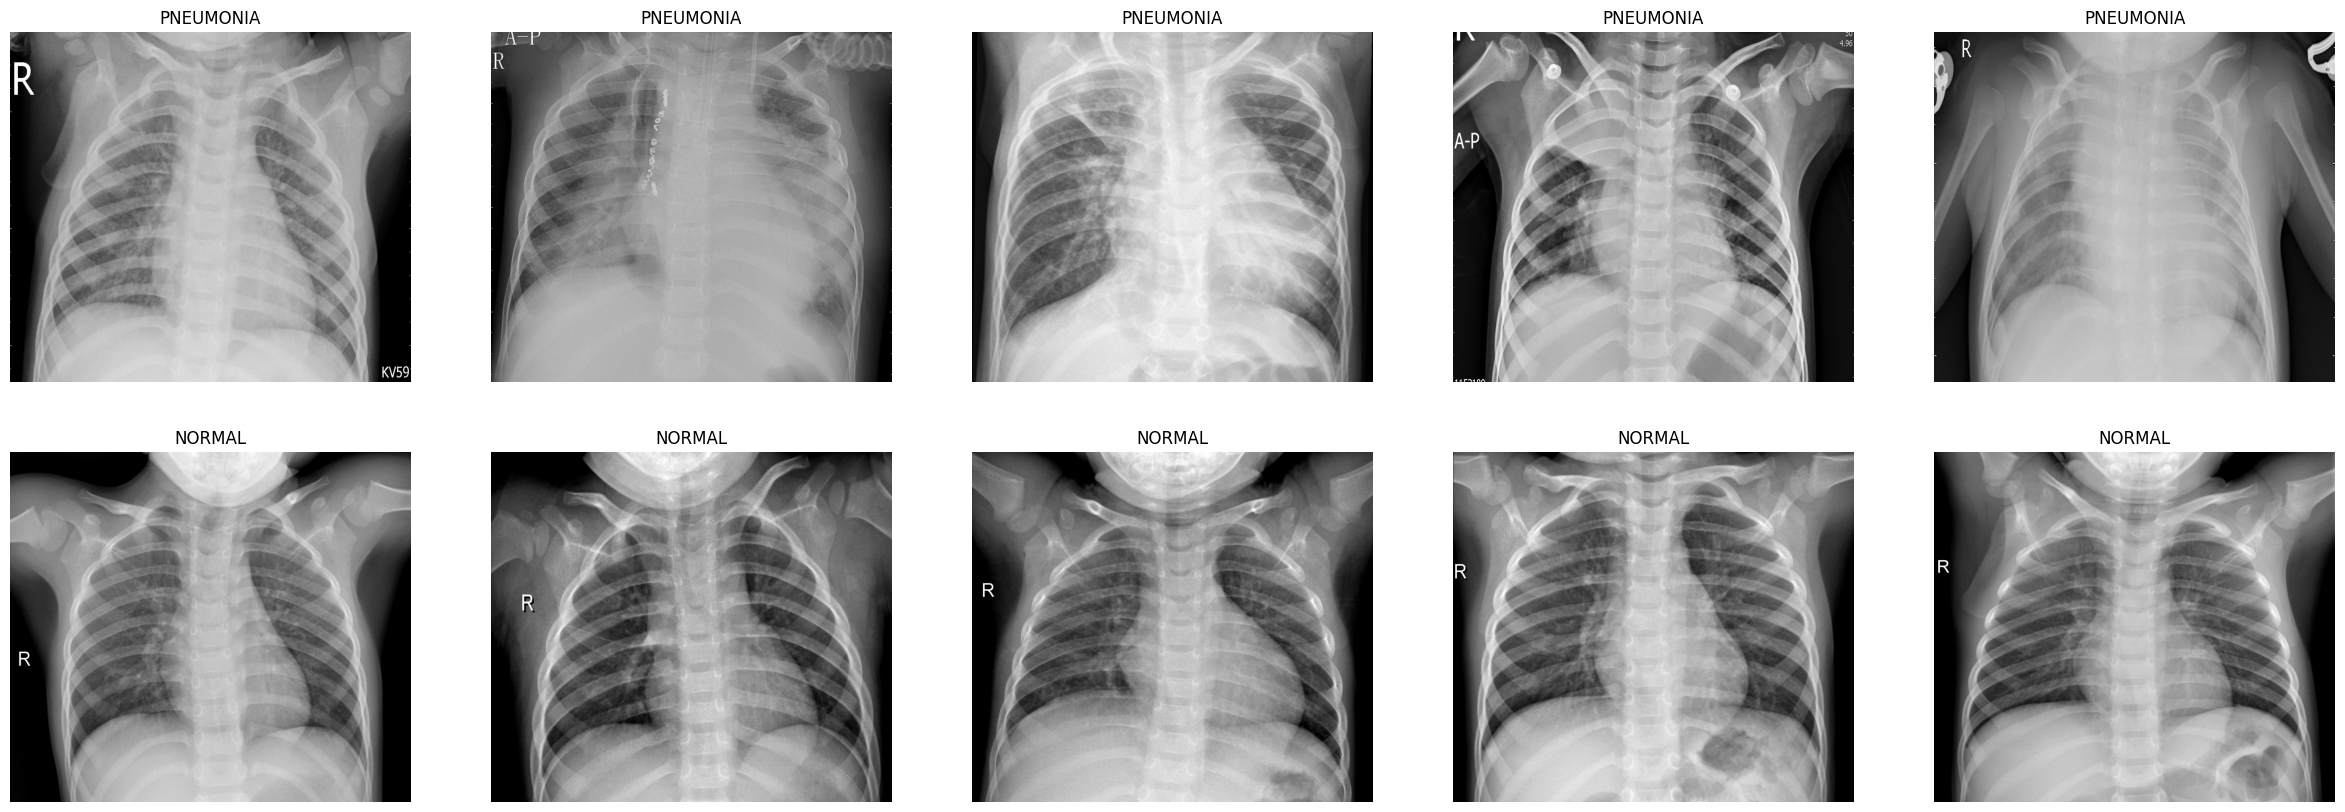

In [29]:
# Get few samples for both the classes
pneumonia_samples = (train_set[train_set["label"] == 1]["image"].iloc[:5]).tolist()
normal_samples = (train_set[train_set["label"] == 0]["image"].iloc[:5]).tolist()

# Concate the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data
f, ax = plt.subplots(2,5, figsize = (30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i % 5].imshow(img, cmap='gray')
    if i < 5:
        ax[i//5, i % 5].set_title("PNEUMONIA")
    else:
        ax[i//5, i % 5].set_title("NORMAL")
    ax[i//5, i % 5].axis('off')
    ax[i//5, i % 5].set_aspect('auto')
plt.show()

#### Plotting the Data Distribution

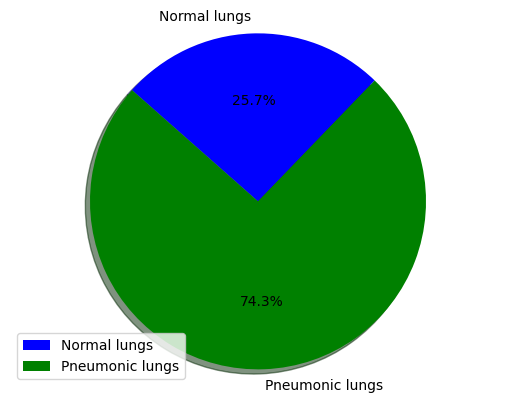

In [30]:
fig1,ax1= plt.subplots()
sizes=[train_normal_count, train_pneumonia_count]
ax1.pie(sizes, startangle=46 ,labels=["Normal lungs","Pneumonic lungs"], autopct="%1.1f%%", shadow=True, colors=["b","g"])
ax1.axis("equal")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Case Distribution')

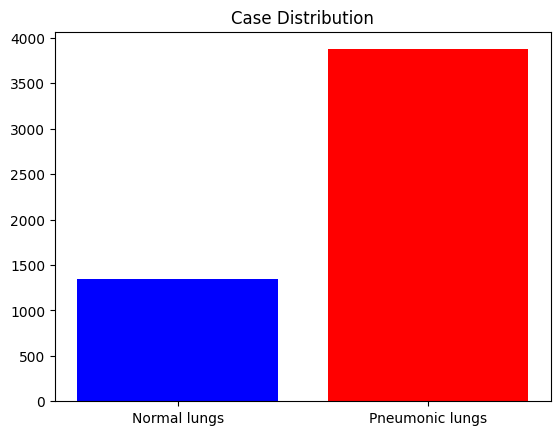

In [31]:
fig2, ax2=plt.subplots()
ax2.bar(height=sizes, x=["Normal lungs", "Pneumonic lungs"], color=["blue", "red"])
plt.title("Case Distribution")

### Data Preparation

In [32]:
labels = ["NORMAL", "PNEUMONIA"]
img_size = 150


import numpy as np
import cv2
import os

def get_training_data(data_dir, labels, img_size=150):
    images = []
    targets = []

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                images.append(resized_arr)
                targets.append(class_num)
            except Exception as e:
                print(f"Error loading image {img}: {e}")
    
    return np.array(images), np.array(targets)


In [33]:
X_train, y_train = get_training_data(train_dir, labels)
X_test, y_test = get_training_data(test_dir, labels)
X_val, y_val = get_training_data(val_dir, labels)


In [34]:
'''# initialize multiple lists
X_train, X_val, X_test = ([], ) * 3
y_train, y_val, y_test = ([], ) * 3

for feature, label in train:
    X_train.append(feature)
    y_train.append(label)

for feature, label in val:
    X_val.append(feature)
    y_val.append(label)

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)'''

'# initialize multiple lists\nX_train, X_val, X_test = ([], ) * 3\ny_train, y_val, y_test = ([], ) * 3\n\nfor feature, label in train:\n    X_train.append(feature)\n    y_train.append(label)\n\nfor feature, label in val:\n    X_val.append(feature)\n    y_val.append(label)\n\nfor feature, label in test:\n    X_test.append(feature)\n    y_test.append(label)'

We perform a grayscale normalization to reduce the effect of illumination's differences. Moreover the CNN converges faster on [0..1] data than on [0..255].

#### Data Normalization

In [35]:
X_train = np.array(X_train) /255
X_val = np.array(X_val) / 255
X_test = np.array(X_test) / 255

#### Reshaping the data for deep learning model

In [36]:
X_train = X_train.reshape (-1, img_size, img_size, 1)
y_train = np.array(y_train)

X_val = X_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

X_test = X_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

#DATA AUGMENTATION

In [37]:
# normalize and augment images
image_generator = ImageDataGenerator(
  featurewise_center = False, # set input mean to 0 over the dataset
  samplewise_center = False, # set each sample mean to 0
  featurewise_std_normalization = False, #divide inputs by std of the dataset
  samplewise_std_normalization = False, # divide each input by its std
  zca_whitening=False,  # apply ZCA whitening
  rotation_range =30, #randomly rotate images in the range
  zoom_range = 0.2, #randomly zoom image
  width_shift_range = 0.1, #randomly shift images horizontally
  height_shift_range = 0.1, #randomly shift images vertically
  horizontal_flip = True, #randomly flip images
  vertical_flip = False) #randomly flip images
  
image_generator.fit(X_train)

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming 'train_dir' and 'val_dir' are your directories for training and validation images
image_generator = ImageDataGenerator(rescale=1./255)

train_generator = image_generator.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # Resize images to 150x150
    color_mode='grayscale',  # Use 'rgb' if the images are in color
    class_mode='binary',  # Change according to your task (e.g., 'categorical' or 'binary')
    batch_size=32,
    shuffle=True
)

val_generator = image_generator.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)
# Assuming 'test_dir' is your test directory
test_generator = image_generator.flow_from_directory(
    test_dir,
    target_size=(150, 150),  # Resize to match input size
    color_mode='grayscale',  # Use 'rgb' for color images
    class_mode='binary',  # Set according to your task ('binary' or 'categorical')
    batch_size=32,
    shuffle=False  # Typically, we don't shuffle the test data
)



Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## 6. Model Development with Hyperparameter Tuning

In [39]:
from keras.layers import MaxPooling2D


In [40]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

/media/Windows/HachathonHub-ModelHive/PneumoniaXRay/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1745016395.965608  470493 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5980 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [41]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.000001)

In [42]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)


(5216, 150, 150, 1) (5216,)
(16, 150, 150, 1) (16,)


In [43]:
with tf.device("/GPU:0"):
    history = model.fit(
        train_generator,
        epochs=15,
        validation_data=val_generator,
        callbacks=[learning_rate_reduction]
    )


/media/Windows/HachathonHub-ModelHive/PneumoniaXRay/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1745016398.272371  482624 service.cc:152] XLA service 0x72363c004620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745016398.272399  482624 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-04-19 04:16:38.341454: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745016398.650889  482624 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/163 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.8056 - loss: 3.6342

I0000 00:00:1745016403.580516  482624 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 146ms/step - accuracy: 0.8463 - loss: 0.9887 - val_accuracy: 0.5000 - val_loss: 23.7978 - learning_rate: 0.0010
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.9573 - loss: 0.1273 - val_accuracy: 0.5000 - val_loss: 31.9791 - learning_rate: 0.0010
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9712 - loss: 0.0812
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 112ms/step - accuracy: 0.9712 - loss: 0.0812 - val_accuracy: 0.5000 - val_loss: 21.0801 - learning_rate: 0.0010
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - accuracy: 0.9861 - loss: 0.0411 - val_accuracy: 0.5000 - val_loss: 4.9973 - learning_rate: 3.0000e-04
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - accuracy: 0.9887 - loss: 0.0301 - val_accuracy: 1.0000 - val_loss: 0.1055 - learning_rate: 3.0000e-04
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - accuracy: 0.994

In [44]:
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_test shape: (624, 150, 150, 1)
y_test shape: (624,)


In [45]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4758 - loss: 6.2108
Loss of the model is -  3.5400328636169434
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4758 - loss: 6.2108
Accuracy of the model is -  71.63461446762085 %


In [46]:
import pickle
os.makedirs('../models', exist_ok=True)
with open('../models/cnn_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("\nModel saved to '../models/cnn_model.pkl'")


Model saved to '../models/cnn_model.pkl'


## 7. Model Evaluation

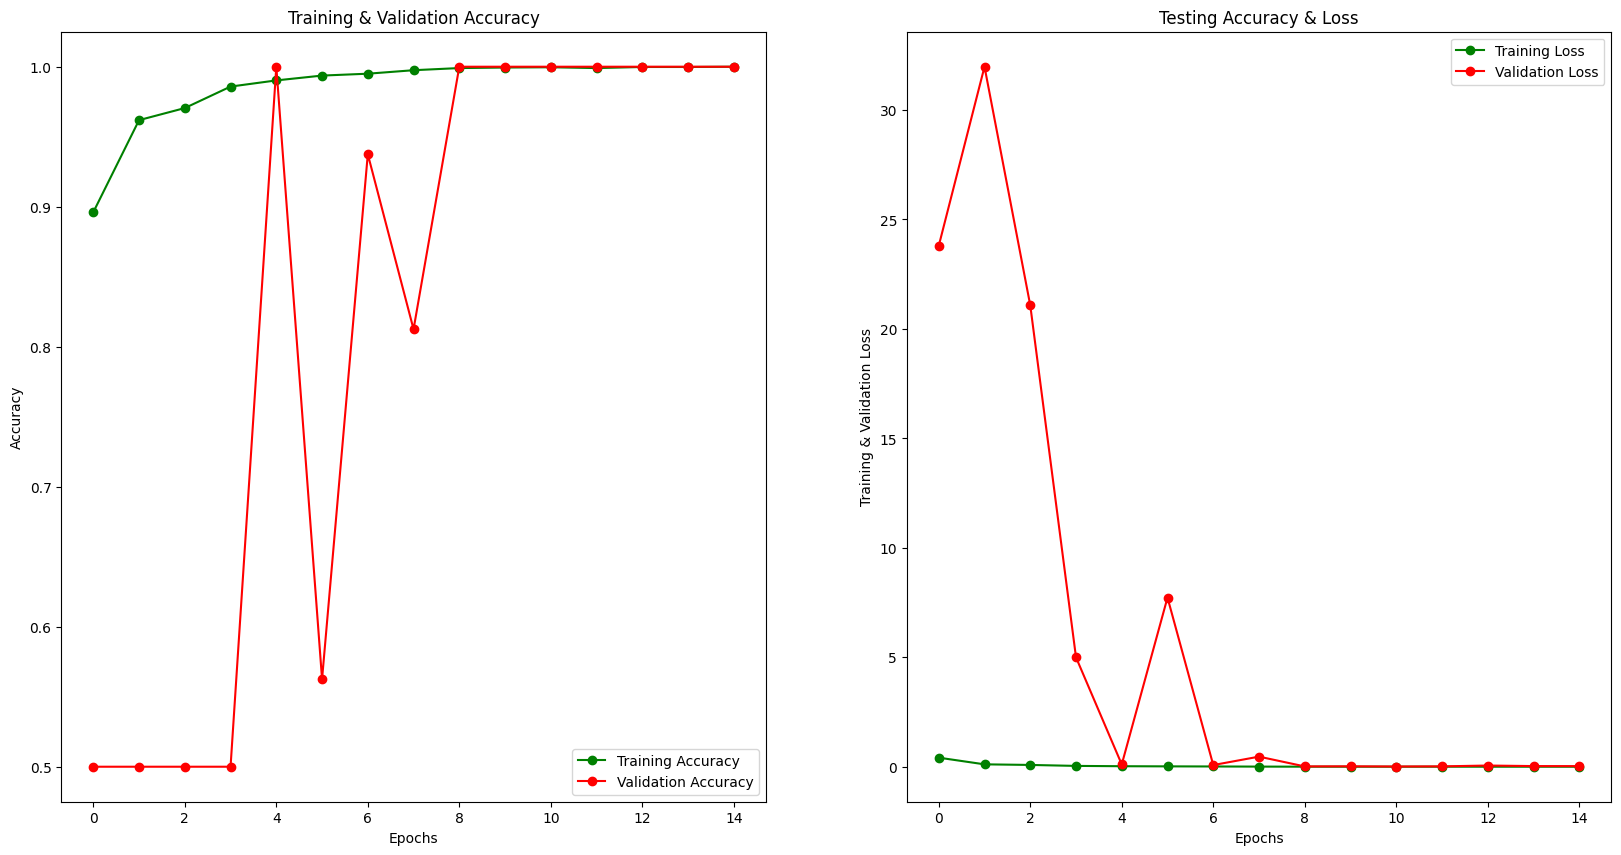

In [47]:
epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [48]:
predictions = (model.predict(X_test) > 0.5).astype("int32")
predictions = predictions.reshape(1, -1)[0]
predictions[:15]


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


array([1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1], dtype=int32)

In [49]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       1.00      0.24      0.39       234
   Normal (Class 1)       0.69      1.00      0.82       390

           accuracy                           0.72       624
          macro avg       0.84      0.62      0.60       624
       weighted avg       0.80      0.72      0.66       624



In [50]:
cm = confusion_matrix(y_test, predictions)
cm


array([[ 57, 177],
       [  0, 390]])

In [51]:
cm = pd.DataFrame(cm, index=['0', '1'], columns=['0', '1'])


<Axes: >

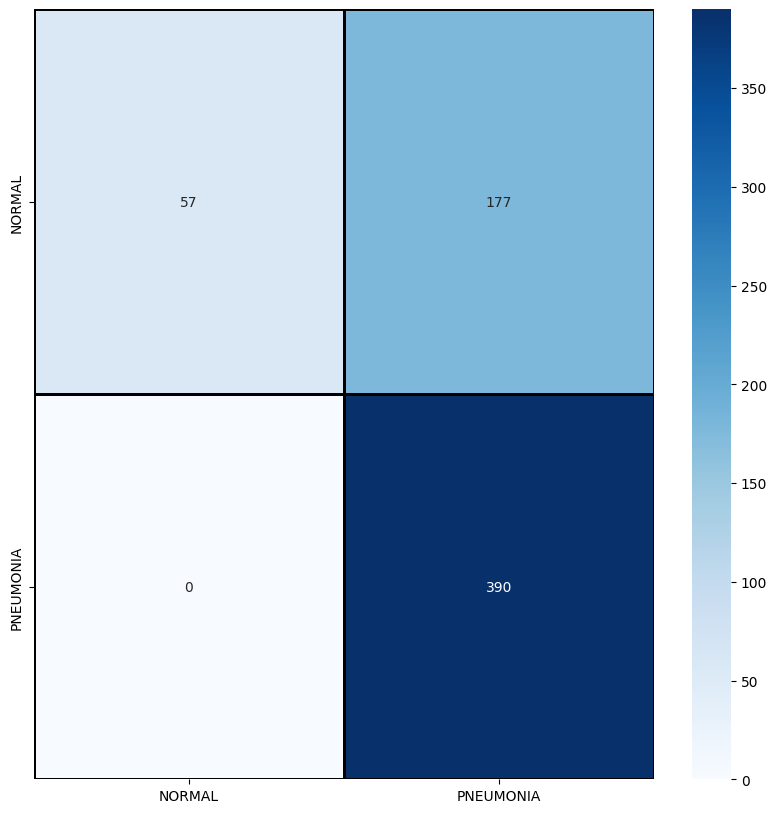

In [52]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [53]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]
